In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import gaussian_kde



In [2]:
# Go to the correct working directory
while not os.getcwd().endswith('Evaluating_Evolutionary_Art'):
    os.chdir(os.path.dirname(os.getcwd()))

# Stack all the pandas dataframes
mydflist = []
for participant_dir in os.listdir(os.path.join(os.getcwd(),'data','archives','Participants')):
    if not participant_dir.endswith('gitkeep'):
        mydflist.append(pd.read_csv(os.path.join(os.getcwd(),'data','archives','Participants',participant_dir,'turingtest.csv')))
full_df = pd.concat(mydflist,axis=0)
full_df = full_df.reset_index(drop=True)

In [3]:

scores = 1*(np.array(full_df['correct_idx']) == np.array(full_df['selected_idx']))
g_idxs = np.array(full_df['g'])
g_idxs = np.where(g_idxs == 'g1', 0, 1)

In [4]:
# full_df['correct_selection'] = full_df['correct_idx'] == full_df['selected_idx']
# total_selections = len(full_df)
# total_correct = full_df['correct_selection'].sum()

In [5]:
# g1_df= full_df[full_df['g'] == 'g1']
# total_selections_g1 = len(g1_df)
# total_correct_g1 = g1_df['correct_selection'].sum()

In [6]:
# g10_df= full_df[full_df['g'] == 'g10']
# total_selections_g10 = len(g10_df)
# total_correct_g10 = g10_df['correct_selection'].sum()

In [7]:
# Model M0, the chance of scoring correctly on the Art Turing Test 
# does not depend on the depth of the generation of the computer-generated art
with pm.Model() as h0:

    alpha = pm.Constant("alpha",1)
    beta = pm.Constant("beta",1)

    theta = pm.Beta(name="theta", alpha=alpha, beta=beta)

    obs = pm.Bernoulli(name="obs",p=theta,observed = scores)

    trace_h0 = pm.sample(20000,return_inferencedata=True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [beta]
>>Metropolis: [alpha]
>NUTS: [theta]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 32 seconds.
/home/guus/Uni/AI_Master/Years/1/sem2/NatCo/NatCo-Project/venv/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

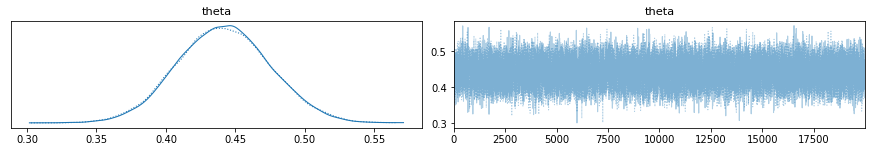

In [7]:
az.plot_trace(trace_h0, var_names="theta")

In [10]:
# Model M0, the chance of scoring correctly on the Art Turing Test 
# depends on the depth of the generation of the computer-generated art

with pm.Model() as h1:

    alpha_g1 = pm.Constant("alpha_g1",2)
    beta_g1 = pm.Constant("beta_g1",1)

    alpha_g10 = pm.Constant("alpha_g10",1)
    beta_g10 = pm.Constant("beta_g10",1)

    theta_g1 = pm.Beta(name="theta_g1", alpha=alpha_g1, beta=beta_g1)
    theta_g10 = pm.Beta(name="theta_g10", alpha=alpha_g10, beta=beta_g10)

    phi = pm.Deterministic('phi', g_idxs*theta_g10 + (1-g_idxs)*theta_g1)

    delta = pm.Deterministic('delta',theta_g1-theta_g10)

    obs = pm.Bernoulli(name='obs',p=phi, observed=scores)

    trace_h1 = pm.sample(1000,return_inferencedata=True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [beta_g10]
>>Metropolis: [alpha_g10]
>>Metropolis: [beta_g1]
>>Metropolis: [alpha_g1]
>NUTS: [theta_g10, theta_g1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
/home/guus/Uni/AI_Master/Years/1/sem2/NatCo/NatCo-Project/venv/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [13]:
# Comparing WAICs
compare_dict = {"h0":trace_h0,"h1":trace_h1}
df_comp_WAIC = az.compare(compare_dict,ic='LOO')
df_comp_WAIC


/home/guus/Uni/AI_Master/Years/1/sem2/NatCo/NatCo-Project/venv/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
h0,0,-151.960683,1.007985,0.000000,1.0,1.741135,0.000000,False,log
h1,1,-152.488616,1.972241,0.527934,0.0,1.884179,0.832481,False,log


In [14]:
matplotlib.rcParams['axes.labelsize'] =15
plt.rcParams["figure.figsize"] = (5,4)

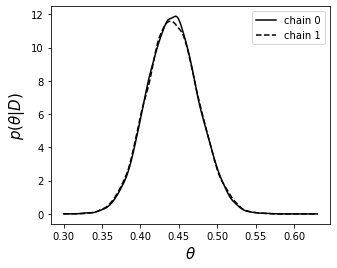

In [15]:
linestyles = ['-','--']
for i,d in enumerate(trace_h0.posterior.theta):
    density = gaussian_kde(d)
    xs = np.linspace(0.3,0.63,200)
    density.covariance_factor = lambda : .25
    plt.plot(xs,density(xs),label=f"chain {i}", c='black',linestyle=linestyles[i])
plt.legend()
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta|D)$')
plt.savefig("theta.png")
plt.show()

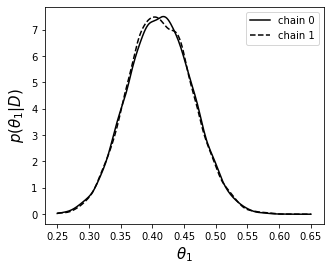

In [112]:
linestyles = ['-','--']
for i,d in enumerate(trace_h1.posterior.theta_g1):
    density = gaussian_kde(d)
    xs = np.linspace(0.25,0.65,200)
    density.covariance_factor = lambda : .25
    plt.plot(xs,density(xs),label=f"chain {i}", c='black',linestyle=linestyles[i])
plt.legend()
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$p(\theta_1|D)$')
plt.savefig("theta_g1.png")

plt.show()

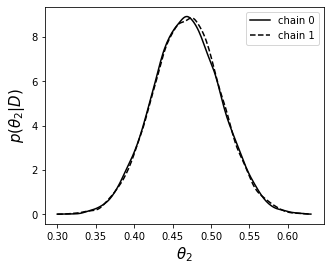

In [113]:
linestyles = ['-','--']
for i,d in enumerate(trace_h1.posterior.theta_g10):
    density = gaussian_kde(d)
    xs = np.linspace(0.3,0.63,200)
    density.covariance_factor = lambda : .25
    plt.plot(xs,density(xs),label=f"chain {i}", c='black',linestyle=linestyles[i])
plt.legend()
plt.xlabel(r'$\theta_2$')
plt.ylabel(r'$p(\theta_2|D)$')
plt.savefig("theta_g10.png")

plt.show()

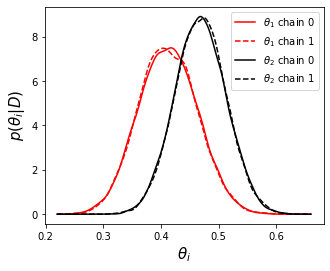

In [114]:
linestyles = ['-','--']
xs = np.linspace(0.22,0.66,200)
for i,d in enumerate(trace_h1.posterior.theta_g1):
    density = gaussian_kde(d)
    density.covariance_factor = lambda : .25
    plt.plot(xs,density(xs),label=fr"$\theta_1$ chain {i}", c='red',linestyle=linestyles[i])
for i,d in enumerate(trace_h1.posterior.theta_g10):
    density = gaussian_kde(d)
    density.covariance_factor = lambda : .25
    plt.plot(xs,density(xs),label=fr"$\theta_2$ chain {i}", c='black',linestyle=linestyles[i])

plt.legend()
plt.xlabel(r'$\theta_i$')
plt.ylabel(r'$p(\theta_i|D)$')
plt.savefig("theta_g10_g1.png")

plt.show()

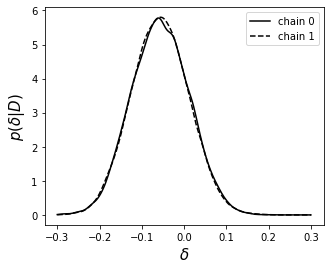

In [115]:
linestyles = ['-','--']
for i,d in enumerate(trace_h1.posterior.delta):
    density = gaussian_kde(d)
    xs = np.linspace(-0.3,0.3,200)
    density.covariance_factor = lambda : .25
    plt.plot(xs,density(xs),label=f"chain {i}", c='black',linestyle=linestyles[i])
plt.legend()
plt.xlabel(r'$\delta$')
plt.ylabel(r'$p(\delta|D)$')
plt.savefig("delta.png")
plt.show()

In [16]:
# Doing a model comparison based on the Bayes Factor
with pm.Model() as bayesfactormodel:

    # Define model 0
    alpha = pm.Constant("alpha",1)
    beta = pm.Constant("beta",1)
    model0 = pm.Beta(name="theta", alpha=alpha, beta=beta)

    # Define model 1
    alpha_g1 = pm.Constant("alpha_g1",2)
    beta_g1 = pm.Constant("beta_g1",1)
    alpha_g10 = pm.Constant("alpha_g10",1)
    beta_g10 = pm.Constant("beta_g10",1)
    theta_g1 = pm.Beta(name="theta_g1", alpha=alpha_g1, beta=beta_g1)
    theta_g10 = pm.Beta(name="theta_g10", alpha=alpha_g10, beta=beta_g10)
    model1 = pm.Deterministic('phi',g_idxs*theta_g10 + (1-g_idxs)*theta_g1)


    # Model the difference in thetas for model 1
    delta = pm.Deterministic('delta',theta_g1-theta_g10)
    
    # Uniform model probability
    p = np.array([0.5, 0.5])
    
    # Model selection
    model_index = pm.Categorical(name='model_index', p=p)
    m = pm.math.switch(model_index, model0, model1)
    
    # Observe the data the selected model
    y = pm.Bernoulli(name='y', p=m, observed=scores)
    
    # Sample
    step0 = pm.ElemwiseCategorical(vars=[model_index], values=[0,1])
    step1 = pm.NUTS()
    trace = pm.sample(20000, step=[step0, step1], chains = 2, return_inferencedata=True, tune=5000)

<ipython-input-16-c260f3dbc542>:27: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  step0 = pm.ElemwiseCategorical(vars=[model_index], values=[0,1])
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>ElemwiseCategorical: [model_index]
>NUTS: [theta_g10, theta_g1, theta]
>CompoundStep
>>Metropolis: [beta_g10]
>>Metropolis: [alpha_g10]
>>Metropolis: [beta_g1]
>>Metropolis: [alpha_g1]
>>Metropolis: [beta]
>>Metropolis: [alpha]


Sampling 2 chains for 5_000 tune and 20_000 draw iterations (10_000 + 40_000 draws total) took 140 seconds.
/home/guus/Uni/AI_Master/Years/1/sem2/NatCo/NatCo-Project/venv/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 150 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5719613727469025, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8823565678839442, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


<ipython-input-17-dbeb5e446e2c>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)


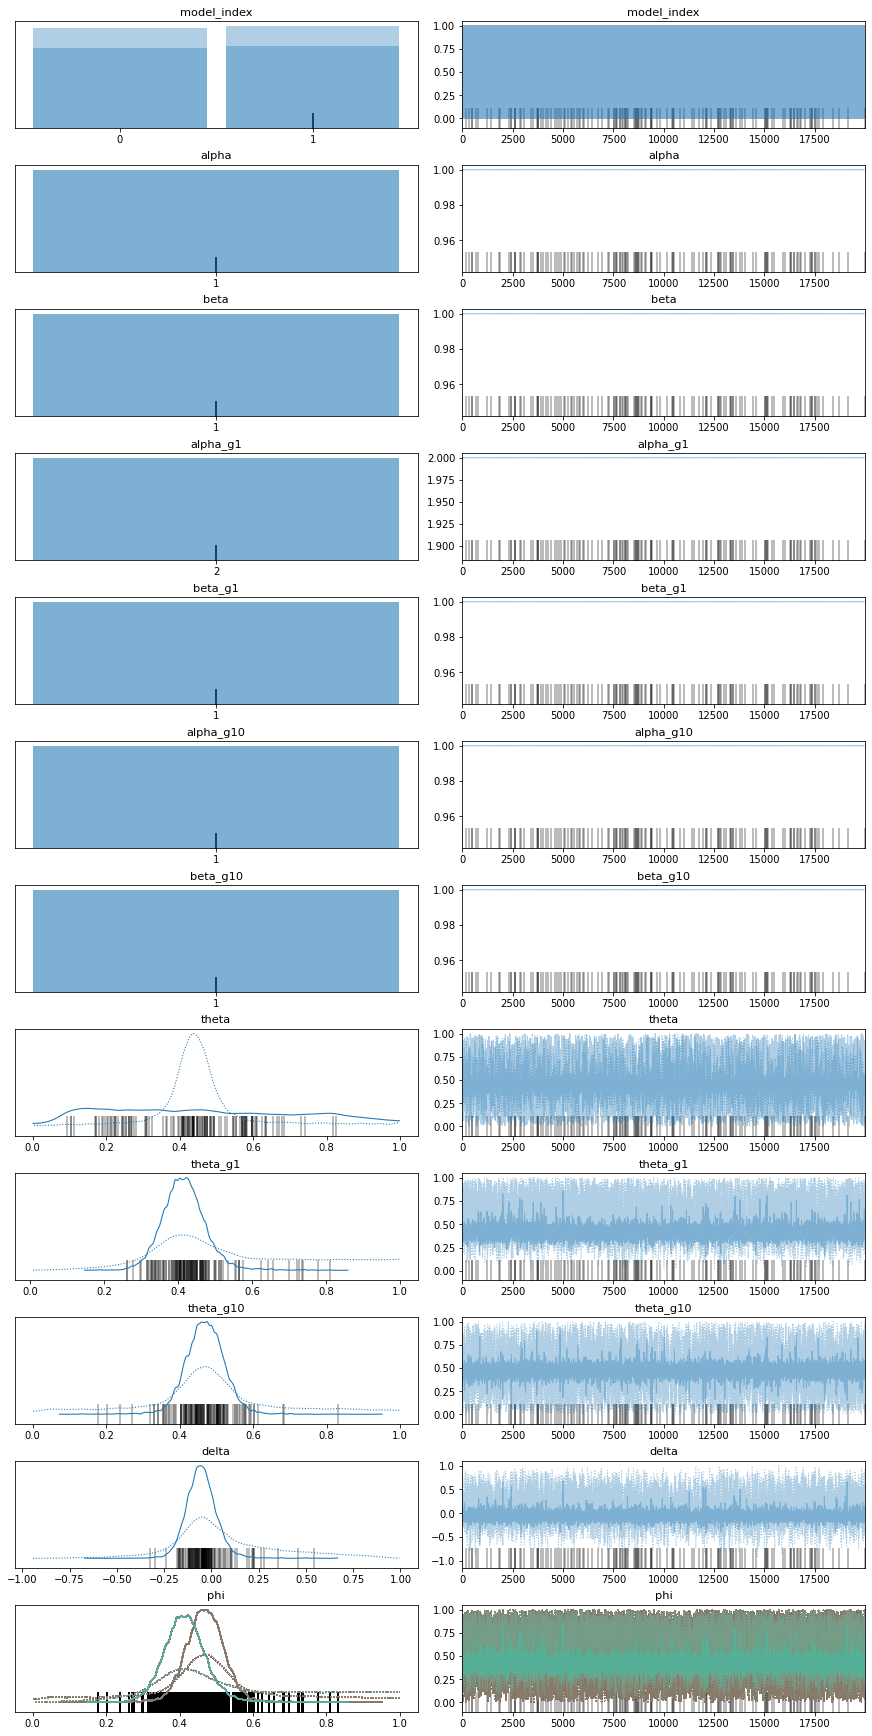

In [17]:
ax.plot_trace(trace)
plt.show()

In [144]:
pM1 = np.array(trace.posterior['model_index'].mean()).item()
pM0 = 1 - pM1
pM0, pM1, (pM0/pM1)*(p[1]/p[0])

(<xarray.DataArray 'model_index' ()>
 array(0.430225),
 <xarray.DataArray 'model_index' ()>
 array(0.569775),
 <xarray.DataArray 'model_index' ()>
 array(0.75507876))

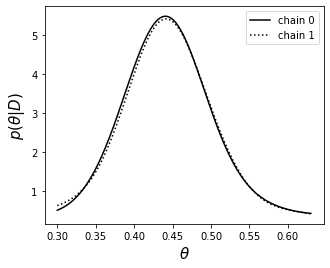

In [138]:
linestyles = ['solid','dotted','dashed','dashdot']
for i,d in enumerate(trace.posterior.theta):
    density = gaussian_kde(d)
    xs = np.linspace(0.3,0.63,200)
    density.covariance_factor = lambda : .25
    plt.plot(xs,density(xs),label=f"chain {i}", c='black',linestyle=linestyles[i])
plt.legend()
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta|D)$')
plt.savefig("theta.png")
plt.show()

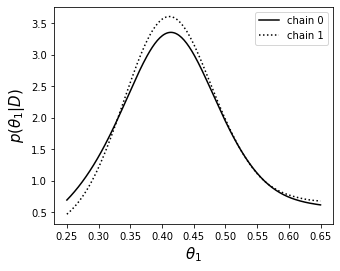

In [139]:
for i,d in enumerate(trace.posterior.theta_g1):
    density = gaussian_kde(d)
    xs = np.linspace(0.25,0.65,200)
    density.covariance_factor = lambda : .25
    plt.plot(xs,density(xs),label=f"chain {i}", c='black',linestyle=linestyles[i])
plt.legend()
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$p(\theta_1|D)$')
plt.savefig("theta_g1.png")

plt.show()

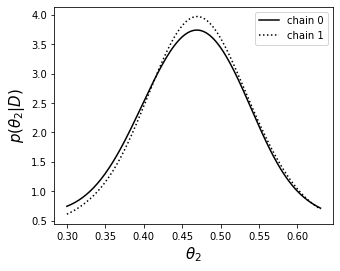

In [140]:
for i,d in enumerate(trace.posterior.theta_g10):
    density = gaussian_kde(d)
    xs = np.linspace(0.3,0.63,200)
    density.covariance_factor = lambda : .25
    plt.plot(xs,density(xs),label=f"chain {i}", c='black',linestyle=linestyles[i])
plt.legend()
plt.xlabel(r'$\theta_2$')
plt.ylabel(r'$p(\theta_2|D)$')
plt.savefig("theta_g10.png")

plt.show()

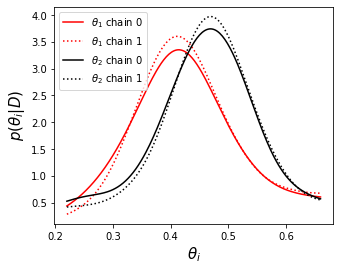

In [141]:
xs = np.linspace(0.22,0.66,200)
for i,d in enumerate(trace.posterior.theta_g1):
    density = gaussian_kde(d)
    density.covariance_factor = lambda : .25
    plt.plot(xs,density(xs),label=fr"$\theta_1$ chain {i}", c='red',linestyle=linestyles[i])
for i,d in enumerate(trace.posterior.theta_g10):
    density = gaussian_kde(d)
    density.covariance_factor = lambda : .25
    plt.plot(xs,density(xs),label=fr"$\theta_2$ chain {i}", c='black',linestyle=linestyles[i])

plt.legend()
plt.xlabel(r'$\theta_i$')
plt.ylabel(r'$p(\theta_i|D)$')
plt.savefig("theta_g10_g1.png")

plt.show()

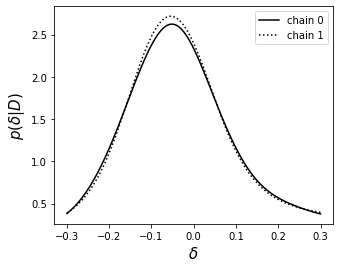

In [142]:
for i,d in enumerate(trace.posterior.delta):
    density = gaussian_kde(d)
    xs = np.linspace(-0.3,0.3,200)
    density.covariance_factor = lambda : .25
    plt.plot(xs,density(xs),label=f"chain {i}", c='black',linestyle=linestyles[i])
plt.legend()
plt.xlabel(r'$\delta$')
plt.ylabel(r'$p(\delta|D)$')
plt.savefig("delta.png")
plt.show()